In [88]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [98]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 44 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

In [99]:
df[df['Juvenile'] == True]['Age'].value_counts(dropna=False)

 17.0    7343
 16.0    4883
 15.0    3084
 14.0    2040
 13.0    1461
 12.0    1126
 11.0     857
 10.0     853
 9.0      723
 8.0      599
 7.0      492
 4.0      475
 3.0      457
 5.0      439
 6.0      433
 2.0      429
 1.0      249
 0.0      199
NaN        55
Name: Age, dtype: int64

In [91]:
df['FiscalYear'] = df['MissionDate']

In [100]:
df.set_index('MissionDate', drop=False, inplace=True)
df.index.name = 'FiscalYear'

In [105]:
g = df.groupby(['CountryOfCitizenship','MissionDate', pd.Grouper(freq='AS-OCT'), 'MissionID', 'R-T', 'PULOC', 'DropLoc', 'Juvenile'])

In [106]:
t = g.agg({'AlienMasterID': pd.Series.nunique})

In [107]:
t = t.unstack('Juvenile')

In [108]:
t

AlienMasterID  \
Juvenile                                                                        False   
CountryOfCitizenship MissionDate FiscalYear MissionID R-T PULOC DropLoc                 
ALGERIA              2010-10-14  2010-10-01 182       T   KMDT  KHRL              1.0   
                     2010-10-15  2010-10-01 187       T   KBFL  KIWA              1.0   
                     2011-01-31  2010-10-01 769       T   KAEX  KMDT              1.0   
                     2012-12-18  2012-10-01 5297      T   KEWR  KAEX              1.0   
                     2014-07-14  2013-10-01 9022      T   KEWR  KAEX              1.0   
                     2016-03-22  2015-10-01 12168     T   KBFI  KIWA              1.0   
                     2016-03-24  2015-10-01 12175     T   KIWA  KAEX              1.0   
                                            12176     T   KAEX  KMIA              1.0   
                     2016-03-31  2015-10-01 12200     T   KAEX  KIWA              1.0   
                                            12202     T   KMIA  KAEX              1.0   
                     2016-04-05  2015-10-01 12274     T   KIWA  KBFI              1.0   
                     2016-05-05  2015-10-01 12421     T   KMIA  KAEX              1.0   
                     2016-05-09  2015-10-01 12441     T   KAEX  KMDT              1.0   
                     2016-05-16  2015-10-01 12498     T   KMDT  KAEX              1.0   
                     2016-05-19  2015-10-01 12513     T   KAEX  KMIA              1.0   
                     2016-06-16  2015-10-01 12669     T   KCSG  KAEX              1.0   
                     2016-09-22  2015-10-01 13124     T   KMIA  KAEX              1.0   
                     2016-09-27  2015-10-01 13148     T   KAEX  KTOL              1.0   
                     2017-04-17  2016-10-01 38916     T   KAEX  KEWR              1.0   
                     2017-07-06  2016-10-01 39238     T   KMIA  KAEX              1.0   
                     2017-07-10  2016-10-01 39252     T   KAEX  KMDT              1.0   
                     2017-07-17  2016-10-01 39279     T   KEWR  KAEX              2.0   
                     2017-07-18  2016-10-01 39286     T   KTOL  KAEX              1.0   
                     2017-07-20  2016-10-01 39292     T   KAEX  KIWA              3.0   
                     2017-07-24  2016-10-01 39306     T   KEWR  KAEX              1.0   
                     2017-07-25  2016-10-01 39314     R   KIWA  DAAG              3.0   
                     2017-08-17  2016-10-01 39415     T   KJAX  KAEX              1.0   
                     2017-08-21  2016-10-01 39427     T   KAEX  KEWR              1.0   
                     2017-08-24  2016-10-01 39442     T   KJAX  KAEX              1.0   
                     2017-11-27  2017-10-01 45631     T   KAEX  KEWR              1.0   
...                                                                               ...   
STATELESS            2018-10-03  2018-10-01 47125     T   KIWA  KAEX              1.0   
                     2018-10-09  2018-10-01 47158     T   KAEX  KAEX              1.0   
                     2018-10-12  2018-10-01 47175     T   KAEX  KIWA              1.0   
                     2018-11-13  2018-10-01 47328     T   KEWR  KFTW              1.0   
BHUTAN               2017-03-03  2016-10-01 38727     T   KSLC  KLAS              1.0   
                     2018-11-20  2018-10-01 47364     T   KEWR  KAEX              1.0   
                     2018-11-21  2018-10-01 47373     T   KAEX  KOMA              1.0   
SURINAME             2017-03-27  2016-10-01 38834     T   KMDT  KAEX              2.0   
                     2017-03-30  2016-10-01 38852     T   KAEX  KMIA              2.0   
                     2017-04-07  2016-10-01 38897     R   KMIA  SMJP              2.0   
                     2018-01-22  2017-10-01 45888     T   KAEX  KEWR              1.0   
                     2018-02-20  2017-10-01 46018     T   KAEX  KEW

In [109]:
t = t['AlienMasterID'].reset_index()

In [110]:
t.columns.name = None

In [111]:
t = t.rename({False: 'AdultCount', True: 'JuvCount'}, axis=1)

In [112]:
t[['AdultCount', 'JuvCount']] = t[['AdultCount', 'JuvCount']].fillna(0)

In [113]:
t['TotalCount'] = t['AdultCount'] + t['JuvCount']

In [114]:
t['JuvPercent'] = t['JuvCount'] / t['TotalCount']

In [115]:
t.set_index('MissionDate', inplace=True)

In [116]:
tr = t[t['R-T'] == 'R'].copy()
tt = t[t['R-T'] == 'T'].copy()

In [117]:
tr.sort_index(inplace=True)
tt.sort_index(inplace=True)

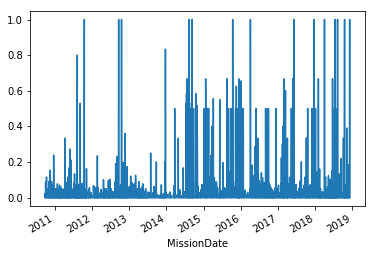

In [118]:
tr['JuvPercent'].plot()

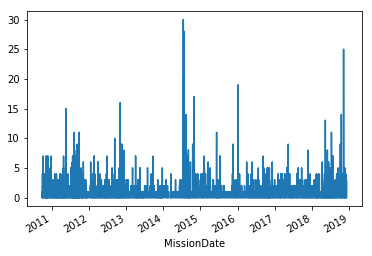

In [119]:
tr['JuvCount'].plot()

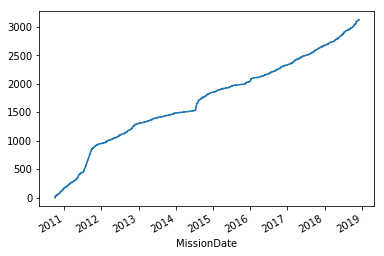

In [120]:
tr['JuvCount'].cumsum().plot()

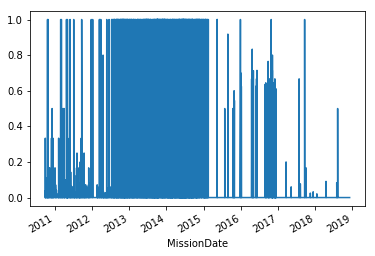

In [121]:
tt['JuvPercent'].plot()

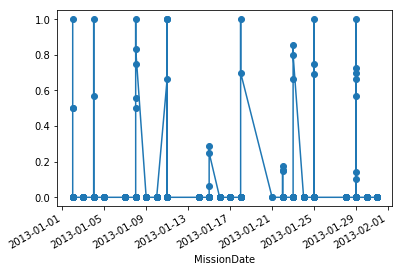

In [122]:
tt['2013-01']['JuvPercent'].plot(style='o-')

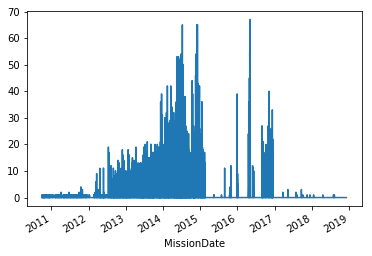

In [123]:
tt['JuvCount'].plot()

In [124]:
all_juv_transfers = tt[tt['JuvPercent'] == 1]
all_juv_removals = tr[tr['JuvPercent'] == 1]

In [125]:
all_juv_removals['JuvCount'].mean()

1.2142857142857142

In [126]:
all_juv_removals['JuvCount'].median()

1.0

In [127]:
all_juv_removals['JuvCount'].max()

3.0

# Juveniles

In [128]:
nationality = 'GUATEMALA'

In [129]:
guate_removals = tr[tr['CountryOfCitizenship'] == nationality].copy()
guate_transfers = tt[tt['CountryOfCitizenship'] == nationality].copy()

In [130]:
guate_removals.head()

,CountryOfCitizenship,FiscalYear,MissionID,R-T,PULOC,DropLoc,AdultCount,JuvCount,TotalCount,JuvPercent
MissionDate,,,,,,,,,,
2010-10-01,GUATEMALA,2010-10-01,132,R,KIWA,MGGT,121.0,0.0,121.0,0.000000
2010-10-01,GUATEMALA,2010-10-01,106,R,KSAT,MGGT,37.0,0.0,37.0,0.000000
2010-10-01,GUATEMALA,2010-10-01,106,R,KHRL,MGGT,67.0,0.0,67.0,0.000000
2010-10-04,GUATEMALA,2010-10-01,112,R,KMIA,MGGT,42.0,4.0,46.0,0.086957
2010-10-05,GUATEMALA,2010-10-01,115,R,KELP,MGGT,23.0,0.0,23.0,0.000000


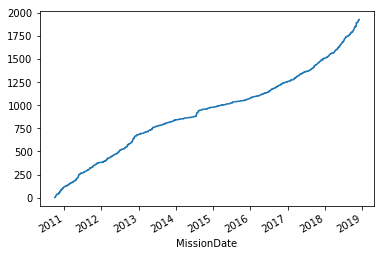

In [131]:
guate_removals['JuvCount'].cumsum().plot()

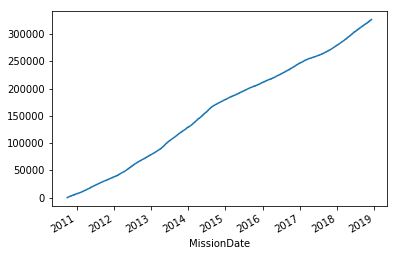

In [132]:
r_cum = guate_removals['TotalCount'].cumsum()
t_cum = guate_removals['TotalCount'].cumsum()

r_cum.plot();

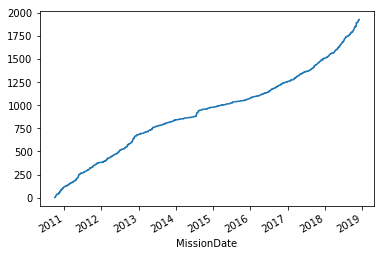

In [133]:
juv_r_cum = guate_removals['JuvCount'].cumsum()

juv_r_cum.plot()

In [134]:
guate_removals['JuvCount'].max()

25.0

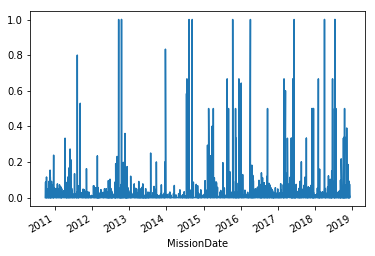

In [135]:
guate_removals['JuvPercent'].plot();

In [136]:
guate_removals[guate_removals['JuvPercent'] == 1]

,CountryOfCitizenship,FiscalYear,MissionID,R-T,PULOC,DropLoc,AdultCount,JuvCount,TotalCount,JuvPercent
MissionDate,,,,,,,,,,
2012-09-20,GUATEMALA,2011-10-01,4634,R,KMIA,MGGT,0.0,1.0,1.0,1.0
2012-10-18,GUATEMALA,2012-10-01,4835,R,KMIA,MGGT,0.0,3.0,3.0,1.0
2014-08-12,GUATEMALA,2013-10-01,9212,R,KSAT,MGGT,0.0,1.0,1.0,1.0
2014-09-12,GUATEMALA,2013-10-01,9411,R,KSAT,MGGT,0.0,1.0,1.0,1.0
2015-10-14,GUATEMALA,2015-10-01,11365,R,KSAT,MGGT,0.0,1.0,1.0,1.0
2016-04-05,GUATEMALA,2015-10-01,12277,R,KLRD,MGGT,0.0,1.0,1.0,1.0
2017-06-08,GUATEMALA,2016-10-01,39135,R,KBRO,MGGT,0.0,2.0,2.0,1.0
2018-04-02,GUATEMALA,2017-10-01,46205,R,KSAT,MGGT,0.0,1.0,1.0,1.0
2018-07-13,GUATEMALA,2017-10-01,46720,R,KSAT,MGGT,0.0,1.0,1.0,1.0


In [137]:
only_guate_juveniles = list(guate_removals[guate_removals['JuvPercent'] == 1]['MissionID'])

In [138]:
only_guate_juveniles

[4634, 4835, 9212, 9411, 11365, 12277, 39135, 46205, 46720]

In [139]:
t[t['MissionID'].isin(only_guate_juveniles)].sort_values(by='MissionID')

,CountryOfCitizenship,FiscalYear,MissionID,R-T,PULOC,DropLoc,AdultCount,JuvCount,TotalCount,JuvPercent
MissionDate,,,,,,,,,,
2012-09-20,GUATEMALA,2011-10-01,4634,R,KAEX,MGGT,115.0,0.0,115.0,0.000000
2012-09-20,GUATEMALA,2011-10-01,4634,R,KMIA,MGGT,0.0,1.0,1.0,1.000000
2012-10-18,ECUADOR,2012-10-01,4835,T,KMIA,KAEX,1.0,0.0,1.0,0.000000
2012-10-18,GUATEMALA,2012-10-01,4835,R,KAEX,MGGT,123.0,0.0,123.0,0.000000
2012-10-18,GUATEMALA,2012-10-01,4835,R,KMIA,MGGT,0.0,3.0,3.0,1.000000
2014-08-12,GUATEMALA,2013-10-01,9212,R,KBRO,MGGT,121.0,1.0,122.0,0.008197
2014-08-12,GUATEMALA,2013-10-01,9212,R,KSAT,MGGT,0.0,1.0,1.0,1.000000
2014-09-12,GUATEMALA,2013-10-01,9411,R,KSAT,MGGT,0.0,1.0,1.0,1.000000
2014-09-12,GUATEMALA,2013-10-01,9411,R,KBRO,MGGT,134.0,0.0,134.0,0.000000


# All juvenile removals

In [141]:
tr.head()

,CountryOfCitizenship,FiscalYear,MissionID,R-T,PULOC,DropLoc,AdultCount,JuvCount,TotalCount,JuvPercent
MissionDate,,,,,,,,,,
2010-10-01,MEXICO,2010-10-01,1695,R,KELP,KHRL,46.0,0.0,46.0,0.0
2010-10-01,GUATEMALA,2010-10-01,132,R,KIWA,MGGT,121.0,0.0,121.0,0.0
2010-10-01,MEXICO,2010-10-01,131,R,KBFL,KSAN,13.0,0.0,13.0,0.0
2010-10-01,MEXICO,2010-10-01,131,R,KOAK,KSAN,43.0,0.0,43.0,0.0
2010-10-01,MEXICO,2010-10-01,108,R,KORD,KHRL,63.0,0.0,63.0,0.0


In [216]:
annual = tr.groupby(['FiscalYear', 'CountryOfCitizenship'])['JuvCount'].sum()

In [219]:
annual = annual.reset_index()
annual.set_index('FiscalYear', inplace=True)

In [241]:
annual.index.year.unique()

Int64Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype='int64', name='FiscalYear')

In [259]:
top5 = list(annual.groupby(['CountryOfCitizenship'])['JuvCount'].sum().sort_values(ascending=False).head().index)

In [263]:
annual.index.unique()

DatetimeIndex(['2010-10-01', '2011-10-01', '2012-10-01', '2013-10-01',
               '2014-10-01', '2015-10-01', '2016-10-01', '2017-10-01',
               '2018-10-01'],
              dtype='datetime64[ns]', name='FiscalYear', freq=None)

In [282]:
top_5_df = pd.DataFrame()
top_5_df = top_5_df.append(annual[annual['CountryOfCitizenship'].isin(top5)])
top_5_df.index = top_5_df.index.year

for year in annual.index.year.unique():
    temp = annual[f'{year}']
    temp2 = temp[~temp['CountryOfCitizenship'].isin(top5)]
    all_other_count = temp2['JuvCount'].sum()
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'JuvCount'],
                            index=[year])
    top_5_df = top_5_df.append(other_df)

In [283]:
top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index + 1]

In [293]:
top_5_df['CountryOfCitizenship'] = top_5_df['CountryOfCitizenship'].astype('category')

In [300]:
top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='JuvCount',
                       aggfunc=np.sum,
                       fill_value=0)

In [309]:
top_5_data

CountryOfCitizenship,ALL OTHERS,EL SALVADOR,GUATEMALA,HAITI,HONDURAS,MEXICO
FY11,15,44,330,0,43,422
FY12,3,8,251,3,17,49
FY13,0,4,229,0,7,19
FY14,3,41,149,0,124,11
FY15,0,71,92,0,29,27
FY16,0,77,160,0,13,19
FY17,0,89,226,14,0,0
FY18,2,36,363,0,1,5
FY19,2,2,133,0,0,0


In [318]:
top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)

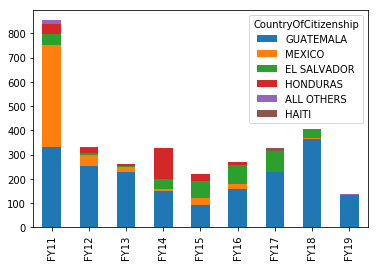

In [319]:
top_5_data.plot(kind='bar', stacked=True)

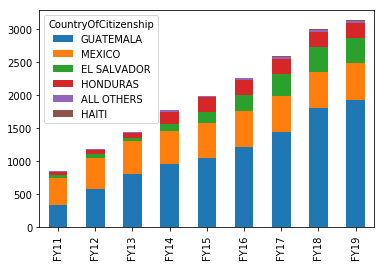

In [320]:
top_5_data.cumsum().plot(kind='bar', stacked=True)

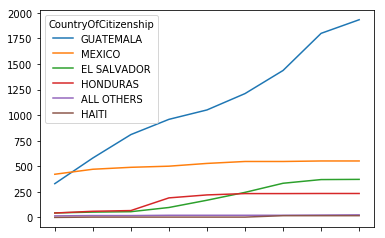

In [325]:
top_5_data.cumsum().plot(kind='line', stacked=False)